# Tutorial 6 (JAX): Transformers and Multi-Head Attention

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)


**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial6/Transformers_and_MHAttention.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial6/Transformers_and_MHAttention.ipynb)  
**Pre-trained models:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/JAX/tutorial6)   
**PyTorch version:**
[![View on RTD](https://img.shields.io/static/v1.svg?logo=readthedocs&label=RTD&message=View%20On%20RTD&color=8CA1AF)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html)   
**Author:** Phillip Lippe

<div class="alert alert-info">

**Note:** This notebook is written in JAX+Flax. It is a 1-to-1 translation of the original notebook written in PyTorch+PyTorch Lightning with almost identical results. For an introduction to JAX, check out our [Tutorial 2 (JAX): Introduction to JAX+Flax](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.html). Further, throughout the notebook, we comment on major differences to the PyTorch version and provide explanations for the major parts of the JAX code.

</div>

---

**Speed comparison**: We note the training times for all models in the PyTorch and the JAX implementation below (PyTorch v1.11, JAX v0.3.13). The models were trained on the same hardware (NVIDIA RTX3090, 24 core CPU) and we slightly adjusted the tutorials to use the exact same training settings (same data loading parameters, evaluation schedule, etc.). Overall, the JAX implementation is almost *4x faster* than PyTorch! However, this is mostly due to the small model and input sizes, and the code has not been explicitly designed for benchmarking. With larger models, larger batch sizes, or smaller GPUs, the speed up is expected to become considerably smaller (see e.g. [Tutorial 15](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial15/Vision_Transformer.html)).
    
| Models            |   PyTorch   |     JAX    |
|-------------------|:-----------:|:----------:|
| Reverse Sequence  | 0min 26sec  | 0min 7sec  |
| Anomaly Detection | 16min 34sec | 3min 45sec |

---

In this tutorial, we will discuss one of the most impactful architectures of the last 2 years: the Transformer model. Since the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) by Vaswani et al. had been published in 2017, the Transformer architecture has continued to beat benchmarks in many domains, most importantly in Natural Language Processing. Transformers with an incredible amount of parameters can generate long, convincing [essays](https://www.theguardian.com/commentisfree/2020/sep/08/robot-wrote-this-article-gpt-3), and opened up new application fields of AI. As the hype of the Transformer architecture seems not to come to an end in the next years, it is important to understand how it works, and have implemented it yourself, which we will do in this notebook.

Despite the huge success of Transformers in NLP, we will _not_ include the NLP domain in our notebook here. Why? Firstly, the Master AI at UvA offers many great NLP courses that will take a closer look at the application of the Transformer architecture in NLP ([NLP2](https://studiegids.uva.nl/xmlpages/page/2020-2021/zoek-vak/vak/79628), [Advanced Topics in Computational Semantics](https://studiegids.uva.nl/xmlpages/page/2020-2021/zoek-vak/vak/80162)). Secondly, assignment 2 takes already a closer look at language generation on character level, on which you could easily apply our transformer architecture. Finally, and most importantly, there is so much more to the Transformer architecture. NLP is the domain the Transformer architecture has been originally proposed for and had the greatest impact on, but it also accelerated research in other domains, recently even [Computer Vision](https://arxiv.org/abs/2010.11929). Thus, we focus here on what makes the Transformer and self-attention so powerful in general. In [Tutorial 15](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial15/Vision_Transformer.html), we will discuss the application of Transformers in Computer Vision.

Below, we import our standard libraries. We use [JAX](https://jax.readthedocs.io/en/latest/) as acceleration backend, [Flax](https://flax.readthedocs.io/en/latest/index.html) for implementing neural networks, and [Optax](https://optax.readthedocs.io/en/latest/index.html) to optimize the models.

In [1]:
## Standard libraries
import os
import numpy as np
import math
import json
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.auto import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial6_jax"

print("Device:", jax.devices()[0])

Device: gpu:0


Two pre-trained models are downloaded below. Make sure to have adjusted your `CHECKPOINT_PATH` before running this code if not already done.

In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial6/"
# Files to download
pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## The Transformer architecture

In the first part of this notebook, we will implement the Transformer architecture by hand. As the architecture is so popular, its main components are already integrated into Flax ([SelfAttention](https://flax.readthedocs.io/en/latest/_autosummary/flax.linen.SelfAttention.html#flax.linen.SelfAttention), [MultiHeadAttention](https://flax.readthedocs.io/en/latest/_autosummary/flax.linen.MultiHeadDotProductAttention.html#flax.linen.MultiHeadDotProductAttention)) and there exist several implementations (e.g. in [Trax](https://trax-ml.readthedocs.io/en/latest/trax.models.html#trax.models.transformer.Transformer)) and pre-trained models (e.g. on [Hugging Face](https://huggingface.co/docs/transformers/index)). However, we will implement it here ourselves, to get through to the smallest details.

There are of course many more tutorials out there about attention and Transformers. Below, we list a few that are worth exploring if you are interested in the topic and might want yet another perspective on the topic after this one:

* [Transformer: A Novel Neural Network Architecture for Language Understanding (Jakob Uszkoreit, 2017)](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html) - The original Google blog post about the Transformer paper, focusing on the application in machine translation.
* [The Illustrated Transformer (Jay Alammar, 2018)](http://jalammar.github.io/illustrated-transformer/) - A very popular and great blog post intuitively explaining the Transformer architecture with many nice visualizations. The focus is on NLP.
* [Attention? Attention! (Lilian Weng, 2018)](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html) - A nice blog post summarizing attention mechanisms in many domains including vision.
* [Illustrated: Self-Attention (Raimi Karim, 2019)](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a) - A nice visualization of the steps of self-attention. Recommended going through if the explanation below is too abstract for you.
* [The Transformer family (Lilian Weng, 2020)](https://lilianweng.github.io/lil-log/2020/04/07/the-transformer-family.html) - A very detailed blog post reviewing more variants of Transformers besides the original one.

### What is Attention?

The attention mechanism describes a recent new group of layers in neural networks that has attracted a lot of interest in the past few years, especially in sequence tasks. There are a lot of different possible definitions of "attention" in the literature, but the one we will use here is the following: _the attention mechanism describes a weighted average of (sequence) elements with the weights dynamically computed based on an input query and elements' keys_. So what does this exactly mean? The goal is to take an average over the features of multiple elements. However, instead of weighting each element equally, we want to weight them depending on their actual values. In other words, we want to dynamically decide on which inputs we want to "attend" more than others. In particular, an attention mechanism has usually four parts we need to specify:

* **Query**: The query is a feature vector that describes what we are looking for in the sequence, i.e. what would we maybe want to pay attention to.
* **Keys**: For each input element, we have a key which is again a feature vector. This feature vector roughly describes what the element is "offering", or when it might be important. The keys should be designed such that we can identify the elements we want to pay attention to based on the query.
* **Values**: For each input element, we also have a value vector. This feature vector is the one we want to average over.
* **Score function**: To rate which elements we want to pay attention to, we need to specify a score function $f_{attn}$. The score function takes the query and a key as input, and output the score/attention weight of the query-key pair. It is usually implemented by simple similarity metrics like a dot product, or a small MLP.


The weights of the average are calculated by a softmax over all score function outputs. Hence, we assign those value vectors a higher weight whose corresponding key is most similar to the query. If we try to describe it with pseudo-math, we can write: 

$$
\alpha_i = \frac{\exp\left(f_{attn}\left(\text{key}_i, \text{query}\right)\right)}{\sum_j \exp\left(f_{attn}\left(\text{key}_j, \text{query}\right)\right)}, \hspace{5mm} \text{out} = \sum_i \alpha_i \cdot \text{value}_i
$$

Visually, we can show the attention over a sequence of words as follows:

<center width="100%" style="padding:25px"><img src="../../tutorial6/attention_example.svg" width="750px"></center>

For every word, we have one key and one value vector. The query is compared to all keys with a score function (in this case the dot product) to determine the weights. The softmax is not visualized for simplicity. Finally, the value vectors of all words are averaged using the attention weights.

Most attention mechanisms differ in terms of what queries they use, how the key and value vectors are defined, and what score function is used. The attention applied inside the Transformer architecture is called **self-attention**. In self-attention, each sequence element provides a key, value, and query. For each element, we perform an attention layer where based on its query, we check the similarity of the all sequence elements' keys, and returned a different, averaged value vector for each element. We will now go into a bit more detail by first looking at the specific implementation of the attention mechanism which is in the Transformer case the scaled dot product attention.

### Scaled Dot Product Attention

The core concept behind self-attention is the scaled dot product attention. Our goal is to have an attention mechanism with which any element in a sequence can attend to any other while still being efficient to compute. The dot product attention takes as input a set of queries $Q\in\mathbb{R}^{T\times d_k}$, keys $K\in\mathbb{R}^{T\times d_k}$ and values $V\in\mathbb{R}^{T\times d_v}$ where $T$ is the sequence length, and $d_k$ and $d_v$ are the hidden dimensionality for queries/keys and values respectively. For simplicity, we neglect the batch dimension for now. The attention value from element $i$ to $j$ is based on its similarity of the query $Q_i$ and key $K_j$, using the dot product as the similarity metric. In math, we calculate the dot product attention as follows:

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

The matrix multiplication $QK^T$ performs the dot product for every possible pair of queries and keys, resulting in a matrix of the shape $T\times T$. Each row represents the attention logits for a specific element $i$ to all other elements in the sequence. On these, we apply a softmax and multiply with the value vector to obtain a weighted mean (the weights being determined by the attention). Another perspective on this attention mechanism offers the computation graph which is visualized below (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

<center width="100%"><img src="../../tutorial6/scaled_dot_product_attn.svg" width="210px"></center>

One aspect we haven't discussed yet is the scaling factor of $1/\sqrt{d_k}$. This scaling factor is crucial to maintain an appropriate variance of attention values after initialization. Remember that we intialize our layers with the intention of having equal variance throughout the model, and hence, $Q$ and $K$ might also have a variance close to $1$. However, performing a dot product over two vectors with a variance $\sigma^2$ results in a scalar having $d_k$-times higher variance: 

$$q_i \sim \mathcal{N}(0,\sigma^2), k_i \sim \mathcal{N}(0,\sigma^2) \to \text{Var}\left(\sum_{i=1}^{d_k} q_i\cdot k_i\right) = \sigma^4\cdot d_k$$


If we do not scale down the variance back to $\sim\sigma^2$, the softmax over the logits will already saturate to $1$ for one random element and $0$ for all others. The gradients through the softmax will be close to zero so that we can't learn the parameters appropriately. Note that the extra factor of $\sigma^2$, i.e., having $\sigma^4$ instead of $\sigma^2$, is usually not an issue, since we keep the original variance $\sigma^2$ close to $1$ anyways.

The block `Mask (opt.)` in the diagram above represents the optional masking of specific entries in the attention matrix. This is for instance used if we stack multiple sequences with different lengths into a batch. To still benefit from parallelization in PyTorch, we pad the sentences to the same length and mask out the padding tokens during the calculation of the attention values. This is usually done by setting the respective attention logits to a very low value. 

After we have discussed the details of the scaled dot product attention block, we can write a function below which computes the output features given the triple of queries, keys, and values:

In [3]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.shape[-1]
    attn_logits = jnp.matmul(q, jnp.swapaxes(k, -2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = jnp.where(mask == 0, -9e15, attn_logits)
    attention = nn.softmax(attn_logits, axis=-1)
    values = jnp.matmul(attention, v)
    return values, attention

Note that our code above supports any additional dimensionality in front of the sequence length so that we can also use it for batches. However, for a better understanding, let's generate a few random queries, keys, and value vectors, and calculate the attention outputs:

In [4]:
seq_len, d_k = 3, 2
main_rng, rand1 = random.split(main_rng)
qkv = random.normal(rand1, (3, seq_len, d_k))
q, k, v = qkv[0], qkv[1], qkv[2]
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 [[-0.6613315   0.70056266]
 [ 0.08239268 -1.7793142 ]
 [-0.04378588  1.0965251 ]]
K
 [[ 1.7257481   0.35568172]
 [ 1.3034704   1.2873708 ]
 [ 1.6871481  -0.5714404 ]]
V
 [[ 1.5129997   1.1050899 ]
 [ 0.27949408 -0.46224892]
 [-1.1003422  -1.1437942 ]]
Values
 [[ 0.376226   -0.14656176]
 [-0.42778552 -0.5989564 ]
 [ 0.4362476  -0.11678296]]
Attention
 [[0.27963293 0.54049295 0.17987415]
 [0.22194655 0.06706189 0.71099156]
 [0.27977085 0.58373076 0.13649833]]


Before continuing, make sure you can follow the calculation of the specific values here, and also check it by hand. It is important to fully understand how the scaled dot product attention is calculated.

### Multi-Head Attention

The scaled dot product attention allows a network to attend over a sequence. However, often there are multiple different aspects a sequence element wants to attend to, and a single weighted average is not a good option for it. This is why we extend the attention mechanisms to multiple heads, i.e. multiple different query-key-value triplets on the same features. Specifically, given a query, key, and value matrix, we transform those into $h$ sub-queries, sub-keys, and sub-values, which we pass through the scaled dot product attention independently. Afterward, we concatenate the heads and combine them with a final weight matrix. Mathematically, we can express this operation as:

$$
\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where } \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V)
\end{split}
$$

We refer to this as Multi-Head Attention layer with the learnable parameters $W_{1...h}^{Q}\in\mathbb{R}^{D\times d_k}$, $W_{1...h}^{K}\in\mathbb{R}^{D\times d_k}$, $W_{1...h}^{V}\in\mathbb{R}^{D\times d_v}$, and $W^{O}\in\mathbb{R}^{h\cdot d_v\times d_{out}}$ ($D$ being the input dimensionality). Expressed in a computational graph, we can visualize it as below (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

<center width="100%"><img src="../../tutorial6/multihead_attention.svg" width="230px"></center>

How are we applying a Multi-Head Attention layer in a neural network, where we don't have an arbitrary query, key, and value vector as input? Looking at the computation graph above, a simple but effective implementation is to set the current feature map in a NN, $X\in\mathbb{R}^{B\times T\times d_{\text{model}}}$, as $Q$, $K$ and $V$ ($B$ being the batch size, $T$ the sequence length, $d_{\text{model}}$ the hidden dimensionality of $X$). The consecutive weight matrices $W^{Q}$, $W^{K}$, and $W^{V}$ can transform $X$ to the corresponding feature vectors that represent the queries, keys, and values of the input. Note that commonly, these weight matrices are initialized with the Xavier initialization. However, the layer is usually not too sensitive to the initialization, as long as the variance of $Q$ and $K$ do not become too large.
With this in mind, we can implement the Multi-Head Attention module below.

In [ ]:
# Helper function to support different mask shapes.
# Output shape supports (batch_size, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is
def expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

In [5]:
class MultiheadAttention(nn.Module):
    embed_dim : int  # Output dimension
    num_heads : int  # Number of parallel heads (h)
    
    def setup(self):
        # Stack all weight matrices 1...h and W^Q, W^K, W^V together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Dense(3*self.embed_dim,
                                 kernel_init=nn.initializers.xavier_uniform(),  # Weights with Xavier uniform init
                                 bias_init=nn.initializers.zeros  # Bias init with zeros
                                )
        self.o_proj = nn.Dense(self.embed_dim,
                               kernel_init=nn.initializers.xavier_uniform(),
                               bias_init=nn.initializers.zeros)

    def __call__(self, x, mask=None):
        batch_size, seq_length, embed_dim = x.shape
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)
        
        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, -1)
        qkv = qkv.transpose(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = jnp.array_split(qkv, 3, axis=-1)
        
        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.transpose(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)
        
        return o, attention

In [6]:
## Test MultiheadAttention implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create attention
mh_attn = MultiheadAttention(embed_dim=128, num_heads=4)
# Initialize parameters of attention with random key and inputs
main_rng, init_rng = random.split(main_rng)
params = mh_attn.init(init_rng, x)['params']
# Apply attention with parameters on the inputs
out, attn = mh_attn.apply({'params': params}, x)
print('Out', out.shape, 'Attention', attn.shape)

del mh_attn, params

Out (3, 16, 128) Attention (3, 4, 16, 16)


One crucial characteristic of the multi-head attention is that it is permutation-equivariant with respect to its inputs. This means that if we switch two input elements in the sequence, e.g. $X_1\leftrightarrow X_2$ (neglecting the batch dimension for now), the output is exactly the same besides the elements 1 and 2 switched. Hence, the multi-head attention is actually looking at the input not as a sequence, but as a set of elements. This property makes the multi-head attention block and the Transformer architecture so powerful and widely applicable! But what if the order of the input is actually important for solving the task, like language modeling? The answer is to encode the position in the input features, which we will take a closer look at later (topic _Positional encodings_ below).

Before moving on to creating the Transformer architecture, we can compare the self-attention operation with our other common layer competitors for sequence data: convolutions and recurrent neural networks. Below you can find a table by [Vaswani et al. (2017)](https://arxiv.org/abs/1706.03762) on the complexity per layer, the number of sequential operations, and maximum path length. The complexity is measured by the upper bound of the number of operations to perform, while the maximum path length represents the maximum number of steps a forward or backward signal has to traverse to reach any other position. The lower this length, the better gradient signals can backpropagate for long-range dependencies. Let's take a look at the table below:


<center width="100%"><img src="../../tutorial6/comparison_conv_rnn.svg" width="600px"></center>

$n$ is the sequence length, $d$ is the representation dimension and $k$ is the kernel size of convolutions. In contrast to recurrent networks, the self-attention layer can parallelize all its operations making it much faster to execute for smaller sequence lengths. However, when the sequence length exceeds the hidden dimensionality, self-attention becomes more expensive than RNNs. One way of reducing the computational cost for long sequences is by restricting the self-attention to a neighborhood of inputs to attend over, denoted by $r$. Nevertheless, there has been recently a lot of work on more efficient Transformer architectures that still allow long dependencies, of which you can find an overview in the paper by [Tay et al. (2020)](https://arxiv.org/abs/2009.06732) if interested.

### Transformer Encoder

Next, we will look at how to apply the multi-head attention block inside the Transformer architecture. Originally, the Transformer model was designed for machine translation. Hence, it got an encoder-decoder structure where the encoder takes as input the sentence in the original language and generates an attention-based representation. On the other hand, the decoder attends over the encoded information and generates the translated sentence in an autoregressive manner, as in a standard RNN. While this structure is extremely useful for Sequence-to-Sequence tasks with the necessity of autoregressive decoding, we will focus here on the encoder part. Many advances in NLP have been made using pure encoder-based Transformer models (if interested, models include the [BERT](https://arxiv.org/abs/1810.04805)-family, the [Vision Transformer](https://arxiv.org/abs/2010.11929), and more), and in our tutorial, we will also mainly focus on the encoder part. If you have understood the encoder architecture, the decoder is a very small step to implement as well. The full Transformer architecture looks as follows (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).:

<center width="100%"><img src="../../tutorial6/transformer_architecture.svg" width="400px"></center>

The encoder consists of $N$ identical blocks that are applied in sequence. Taking as input $x$, it is first passed through a Multi-Head Attention block as we have implemented above. The output is added to the original input using a residual connection, and we apply a consecutive Layer Normalization on the sum. Overall, it calculates $\text{LayerNorm}(x+\text{Multihead}(x,x,x))$ ($x$ being $Q$, $K$ and $V$ input to the attention layer). The residual connection is crucial in the Transformer architecture for two reasons: 

1. Similar to ResNets, Transformers are designed to be very deep. Some models contain more than 24 blocks in the encoder. Hence, the residual connections are crucial for enabling a smooth gradient flow through the model.
2. Without the residual connection, the information about the original sequence is lost. Remember that the Multi-Head Attention layer ignores the position of elements in a sequence, and can only learn it based on the input features. Removing the residual connections would mean that this information is lost after the first attention layer (after initialization), and with a randomly initialized query and key vector, the output vectors for position $i$ has no relation to its original input. All outputs of the attention are likely to represent similar/same information, and there is no chance for the model to distinguish which information came from which input element. An alternative option to residual connection would be to fix at least one head to focus on its original input, but this is very inefficient and does not have the benefit of the improved gradient flow.

The Layer Normalization also plays an important role in the Transformer architecture as it enables faster training and provides small regularization. Additionally, it ensures that the features are in a similar magnitude among the elements in the sequence. We are not using Batch Normalization because it depends on the batch size which is often small with Transformers (they require a lot of GPU memory), and BatchNorm has shown to perform particularly bad in language as the features of words tend to have a much higher variance (there are many, very rare words which need to be considered for a good distribution estimate).

Additionally to the Multi-Head Attention, a small fully connected feed-forward network is added to the model, which is applied to each position separately and identically. Specifically, the model uses a Linear$\to$ReLU$\to$Linear MLP. The full transformation including the residual connection can be expressed as:  

$$
\begin{split}
    \text{FFN}(x) & = \max(0, xW_1+b_1)W_2 + b_2\\
    x & = \text{LayerNorm}(x + \text{FFN}(x))
\end{split}
$$

This MLP adds extra complexity to the model and allows transformations on each sequence element separately. You can imagine as this allows the model to "post-process" the new information added by the previous Multi-Head Attention, and prepare it for the next attention block. Usually, the inner dimensionality of the MLP is 2-8$\times$ larger than $d_{\text{model}}$, i.e. the dimensionality of the original input $x$. The general advantage of a wider layer instead of a narrow, multi-layer MLP is the faster, parallelizable execution.

Finally, after looking at all parts of the encoder architecture, we can start implementing it below. We first start by implementing a single encoder block. Additionally to the layers described above, we will add dropout layers in the MLP and on the output of the MLP and Multi-Head Attention for regularization.

In [7]:
class EncoderBlock(nn.Module):
    input_dim : int  # Input dimension is needed here since it is equal to the output dimension (residual connection)
    num_heads : int
    dim_feedforward : int
    dropout_prob : float
    
    def setup(self):
        # Attention layer
        self.self_attn = MultiheadAttention(embed_dim=self.input_dim, 
                                            num_heads=self.num_heads)
        # Two-layer MLP
        self.linear = [
            nn.Dense(self.dim_feedforward),
            nn.Dropout(self.dropout_prob),
            nn.relu,
            nn.Dense(self.input_dim)
        ]
        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()
        self.dropout = nn.Dropout(self.dropout_prob)

    def __call__(self, x, mask=None, train=True):
        # Attention part
        attn_out, _ = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out, deterministic=not train)
        x = self.norm1(x)
        
        # MLP part
        linear_out = x
        for l in self.linear:
            linear_out = l(linear_out) if not isinstance(l, nn.Dropout) else l(linear_out, deterministic=not train)
        x = x + self.dropout(linear_out, deterministic=not train)
        x = self.norm2(x)
        
        return x

In [8]:
## Test EncoderBlock implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create encoder block
encblock = EncoderBlock(input_dim=128, num_heads=4, dim_feedforward=512, dropout_prob=0.1)
# Initialize parameters of encoder block with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = encblock.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']
# Apply encoder block with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
out = encblock.apply({'params': params}, x, train=True, rngs={'dropout': dropout_apply_rng})
print('Out', out.shape)

del encblock, params

Out (3, 16, 128)


Based on this block, we can implement a module for the full Transformer encoder. Additionally to a forward function that iterates through the sequence of encoder blocks, we also provide a function called `get_attention_maps`. The idea of this function is to return the attention probabilities for all Multi-Head Attention blocks in the encoder. This helps us in understanding, and in a sense, explaining the model. However, the attention probabilities should be interpreted with a grain of salt as it does not necessarily reflect the true interpretation of the model (there is a series of papers about this, including [Attention is not Explanation](https://arxiv.org/abs/1902.10186) and [Attention is not not Explanation](https://arxiv.org/abs/1908.04626)).

In [9]:
class TransformerEncoder(nn.Module):
    num_layers : int
    input_dim : int
    num_heads : int
    dim_feedforward : int
    dropout_prob : float
    
    def setup(self):
        self.layers = [EncoderBlock(self.input_dim, self.num_heads, self.dim_feedforward, self.dropout_prob) for _ in range(self.num_layers)]

    def __call__(self, x, mask=None, train=True):
        for l in self.layers:
            x = l(x, mask=mask, train=train)
        return x

    def get_attention_maps(self, x, mask=None, train=True):
        # A function to return the attention maps within the model for a single application
        # Used for visualization purpose later
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask)
            attention_maps.append(attn_map)
            x = l(x, mask=mask, train=train)
        return attention_maps

In [10]:
## Test TransformerEncoder implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create Transformer encoder
transenc = TransformerEncoder(num_layers=5, 
                              input_dim=128,
                              num_heads=4,
                              dim_feedforward=256,
                              dropout_prob=0.15)
# Initialize parameters of transformer with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transenc.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']
# Apply transformer with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
# Instead of passing params and rngs every time to a function call, we can bind them to the module
binded_mod = transenc.bind({'params': params}, rngs={'dropout': dropout_apply_rng})
out = binded_mod(x, train=True)
print('Out', out.shape)
attn_maps = binded_mod.get_attention_maps(x, train=True)
print('Attention maps', len(attn_maps), attn_maps[0].shape)

del transenc, binded_mod, params

Out (3, 16, 128)
Attention maps 5 (3, 4, 16, 16)


### Positional encoding

We have discussed before that the Multi-Head Attention block is permutation-equivariant, and cannot distinguish whether an input comes before another one in the sequence or not. In tasks like language understanding, however, the position is important for interpreting the input words. The position information can therefore be added via the input features. We could learn a embedding for every possible position, but this would not generalize to a dynamical input sequence length. Hence, the better option is to use feature patterns that the network can identify from the features and potentially generalize to larger sequences. The specific pattern chosen by Vaswani et al. are sine and cosine functions of different frequencies, as follows:

$$
PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}
$$

$PE_{(pos,i)}$ represents the position encoding at position $pos$ in the sequence, and hidden dimensionality $i$. These values, concatenated for all hidden dimensions, are added to the original input features (in the Transformer visualization above, see "Positional encoding"), and constitute the position information. We distinguish between even ($i \text{ mod } 2=0$) and uneven ($i \text{ mod } 2=1$) hidden dimensionalities where we apply a sine/cosine respectively. The intuition behind this encoding is that you can represent $PE_{(pos+k,:)}$ as a linear function of $PE_{(pos,:)}$, which might allow the model to easily attend to relative positions. The wavelengths in different dimensions range from $2\pi$ to $10000\cdot 2\pi$.

The positional encoding is implemented below.

In [11]:
class PositionalEncoding(nn.Module):
    d_model : int         # Hidden dimensionality of the input.
    max_len : int = 5000  # Maximum length of a sequence to expect.

    def setup(self):
        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = np.zeros((self.max_len, self.d_model))
        position = np.arange(0, self.max_len, dtype=np.float32)[:,None]
        div_term = np.exp(np.arange(0, self.d_model, 2) * (-math.log(10000.0) / self.d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[None]
        self.pe = jax.device_put(pe)

    def __call__(self, x):
        x = x + self.pe[:, :x.shape[1]]
        return x

To understand the positional encoding, we can visualize it below. We will generate an image of the positional encoding over hidden dimensionality and position in a sequence. Each pixel, therefore, represents the change of the input feature we perform to encode the specific position. Let's do it below.

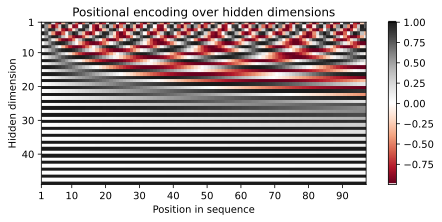

In [12]:
# Create encoding block, bind to access positional encoding (module has no parameters)
encod_block = PositionalEncoding(d_model=48, max_len=96).bind({})
# Obtain positional encodings as numpy array
pe = jax.device_get(encod_block.pe.squeeze().T)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

You can clearly see the sine and cosine waves with different wavelengths that encode the position in the hidden dimensions. Specifically, we can look at the sine/cosine wave for each hidden dimension separately, to get a better intuition of the pattern. Below we visualize the positional encoding for the hidden dimensions $1$, $2$, $3$ and $4$.

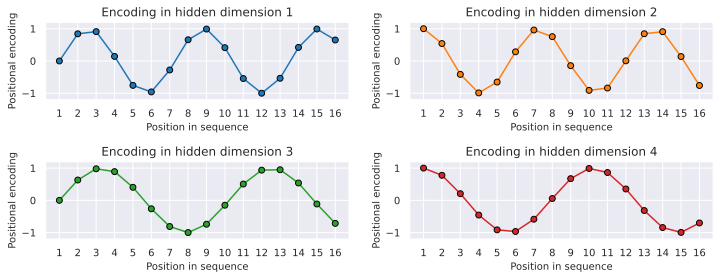

In [13]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

As we can see, the patterns between the hidden dimension $1$ and $2$ only differ in the starting angle. The wavelength is $2\pi$, hence the repetition after position $6$. The hidden dimensions $2$ and $3$ have about twice the wavelength. 

### Learning rate warm-up

One commonly used technique for training a Transformer is learning rate warm-up. This means that we gradually increase the learning rate from 0 on to our originally specified learning rate in the first few iterations. Thus, we slowly start learning instead of taking very large steps from the beginning. In fact, training a deep Transformer without learning rate warm-up can make the model diverge and achieve a much worse performance on training and testing. Take for instance the following plot by [Liu et al. (2019)](https://arxiv.org/pdf/1908.03265.pdf) comparing Adam-vanilla (i.e. Adam without warm-up) vs Adam with a warm-up:

<center width="100%"><img src="../../tutorial6/warmup_loss_plot.svg" width="350px"></center>

Clearly, the warm-up is a crucial hyperparameter in the Transformer architecture. Why is it so important? There are currently two common explanations. Firstly, Adam uses the bias correction factors which however can lead to a higher variance in the adaptive learning rate during the first iterations. Improved optimizers like [RAdam](https://arxiv.org/abs/1908.03265) have been shown to overcome this issue, not requiring warm-up for training Transformers. Secondly, the iteratively applied Layer Normalization across layers can lead to very high gradients during the first iterations, which can be solved by using [Pre-Layer Normalization](https://proceedings.icml.cc/static/paper_files/icml/2020/328-Paper.pdf) (similar to Pre-Activation ResNet), or replacing Layer Normalization by other techniques ([Adaptive Normalization](https://proceedings.icml.cc/static/paper_files/icml/2020/328-Paper.pdf), [Power Normalization](https://arxiv.org/abs/2003.07845)). 

Nevertheless, many applications and papers still use the original Transformer architecture with Adam, because warm-up is a simple, yet effective way of solving the gradient problem in the first iterations. There are many different schedulers we could use. For instance, the original Transformer paper used an exponential decay scheduler with a warm-up. However, the currently most popular scheduler is the cosine warm-up scheduler, which combines warm-up with a cosine-shaped learning rate decay. In Optax, this learning rate scheduler is also implemented in `optax.warmup_cosine_decay_schedule`, but let's manually implement it below, and visualize the learning rate factor over epochs. 

In [14]:
def cosine_warmup_schedule(base_lr: float, warmup: int, max_iters: int):
    assert warmup > 0 and max_iters > 0
    # Create function to return lr based on iteration count
    def get_lr(train_iter):
        lr_factor = 0.5 * (1 + np.cos(np.pi * train_iter / max_iters))
        if train_iter <= warmup:
            lr_factor *= train_iter * 1.0 / warmup
        return lr_factor * base_lr
    return get_lr

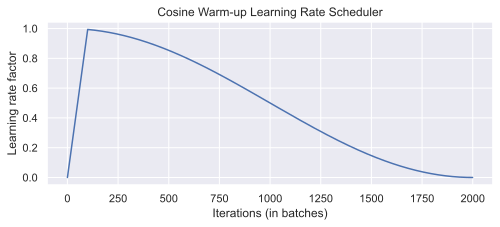

In [15]:
lr_scheduler = cosine_warmup_schedule(base_lr=1.0, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

In the first 100 iterations, we increase the learning rate factor from 0 to 1, whereas for all later iterations, we decay it using the cosine wave.

### Full Transformer model

Finally, we can embed the Transformer architecture into a full architecture. We will implement a template for a classifier based on the Transformer encoder. Thereby, we have a prediction output per sequence element. If we would need a classifier over the whole sequence, the common approach is to add an additional `[CLS]` token to the sequence, representing the classifier token. However, here we focus on tasks where we have one output per element. 

Additionally to the Transformer architecture, we add a small input network (maps input dimensions to model dimensions), the positional encoding, and an output network (transforms output encodings to predictions). We also add the learning rate scheduler, which takes a step each iteration instead of once per epoch. This is needed for the warmup and the smooth cosine decay. The training, validation, and test step is left empty for now and will be filled for our task-specific models.

In [16]:
class TransformerPredictor(nn.Module):
    model_dim : int                   # Hidden dimensionality to use inside the Transformer
    num_classes : int                 # Number of classes to predict per sequence element
    num_heads : int                   # Number of heads to use in the Multi-Head Attention blocks
    num_layers : int                  # Number of encoder blocks to use
    dropout_prob : float = 0.0        # Dropout to apply inside the model
    input_dropout_prob : float = 0.0  # Dropout to apply on the input features

    def setup(self):
        # Input dim -> Model dim
        self.input_dropout = nn.Dropout(self.input_dropout_prob)
        self.input_layer = nn.Dense(self.model_dim)
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(self.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.num_layers,
                                              input_dim=self.model_dim,
                                              dim_feedforward=2*self.model_dim,
                                              num_heads=self.num_heads,
                                              dropout_prob=self.dropout_prob)
        # Output classifier per sequence lement
        self.output_net = [
            nn.Dense(self.model_dim),
            nn.LayerNorm(),
            nn.relu,
            nn.Dropout(self.dropout_prob),
            nn.Dense(self.num_classes)
        ]

    def __call__(self, x, mask=None, add_positional_encoding=True, train=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
            train - If True, dropout is stochastic
        """
        x = self.input_dropout(x, deterministic=not train)
        x = self.input_layer(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask, train=train)
        for l in self.output_net:
            x = l(x) if not isinstance(l, nn.Dropout) else l(x, deterministic=not train)
        return x

    def get_attention_maps(self, x, mask=None, add_positional_encoding=True, train=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_dropout(x, deterministic=not train)
        x = self.input_layer(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask, train=train)
        return attention_maps

In [17]:
## Test TransformerPredictor implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 64))
# Create Transformer encoder
transpre = TransformerPredictor(num_layers=5, 
                                model_dim=128,
                                num_classes=10,
                                num_heads=4,
                                dropout_prob=0.15,
                                input_dropout_prob=0.05)
# Initialize parameters of transformer predictor with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transpre.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']
# Apply transformer predictor with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
# Instead of passing params and rngs every time to a function call, we can bind them to the module
binded_mod = transpre.bind({'params': params}, rngs={'dropout': dropout_apply_rng})
out = binded_mod(x, train=True)
print('Out', out.shape)
attn_maps = binded_mod.get_attention_maps(x, train=True)
print('Attention maps', len(attn_maps), attn_maps[0].shape)

del transpre, binded_mod, params

Out (3, 16, 10)
Attention maps 5 (3, 4, 16, 16)


### Trainer module

Finally, we add the missing parts needed for training a model in JAX and Flax. Note that we leave the specific loss function unimplemented, since this function depends on different tasks we do below.

In the optimization, we use the Adam optimizer with our previously discussed cosine scheduler. Additionally, we use the optax transformation `optax.clip_by_global_norm` ([documentation](https://optax.readthedocs.io/en/latest/api.html#optax.clip_by_global_norm)). This clips the norm of the gradients for all parameters before taking an optimizer step and prevents the model from diverging if we obtain very high gradients at, for instance, sharp loss surfaces (see many good blog posts on gradient clipping, like [DeepAI glossary](https://deepai.org/machine-learning-glossary-and-terms/gradient-clipping)). For Transformers, gradient clipping can help to further stabilize the training during the first few iterations, and also afterward. The clip value is usually between 0.5 and 10, depending on how harsh you want to clip large gradients.

In [18]:
class TrainerModule:
    
    def __init__(self, model_name, exmp_batch, max_iters, lr=1e-3, warmup=100, seed=42, **model_kwargs):
        """
        Inputs:
            model_name - Name of the model. Used for saving and checkpointing
            exmp_batch - Example batch to the model for initialization
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            seed - Seed to use for model init
        """
        super().__init__()
        self.model_name = model_name
        self.max_iters = max_iters
        self.lr = lr
        self.warmup = warmup
        self.seed = seed
        # Create empty model. Note: no parameters yet
        self.model = TransformerPredictor(**model_kwargs)
        # Prepare logging
        self.log_dir = os.path.join(CHECKPOINT_PATH, self.model_name)
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_batch)
        
    def batch_to_input(self, exmp_batch):
        # Map batch to input data to the model
        # To be implemented in a task specific sub-class
        raise NotImplementedError
        
    def get_loss_function(self):
        # Return a function that calculates the loss for a batch
        # To be implemented in a task specific sub-class
        raise NotImplementedError
        
    def create_functions(self):
        # Create jitted train and eval functions
        calculate_loss = self.get_loss_function()
        
        # Training function
        def train_step(state, rng, batch):
            loss_fn = lambda params: calculate_loss(params, rng, batch, train=True)
            ret, grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            loss, acc, rng = ret[0], *ret[1]
            state = state.apply_gradients(grads=grads)
            return state, rng, loss, acc
        self.train_step = jax.jit(train_step)
        
        # Evaluation function
        def eval_step(state, rng, batch):
            _, (acc, rng) = calculate_loss(state.params, rng, batch, train=False)
            return acc, rng
        self.eval_step = jax.jit(eval_step)
        
    def init_model(self, exmp_batch):
        # Initialize model
        self.rng = jax.random.PRNGKey(self.seed)
        self.rng, init_rng, dropout_init_rng = jax.random.split(self.rng, 3)
        exmp_input = self.batch_to_input(exmp_batch)
        params = self.model.init({'params': init_rng, 'dropout': dropout_init_rng}, exmp_input, train=True)['params']
        # Initialize learning rate schedule and optimizer
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=self.lr,
            warmup_steps=self.warmup,
            decay_steps=self.max_iters,
            end_value=0.0
        )
        optimizer = optax.chain(
            optax.clip_by_global_norm(1.0),  # Clip gradients at norm 1
            optax.adam(lr_schedule)
        )
        # Initialize training state
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=optimizer)
        
    def train_model(self, train_loader, val_loader, num_epochs=500):
        # Train model for defined number of epochs
        best_acc = 0.0
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(train_loader, epoch=epoch_idx)
            if epoch_idx % 5 == 0:
                eval_acc = self.eval_model(val_loader)
                self.logger.add_scalar('val/accuracy', eval_acc, global_step=epoch_idx)
                if eval_acc >= best_acc:
                    best_acc = eval_acc
                    self.save_model(step=epoch_idx)
                self.logger.flush()
                
    def train_epoch(self, train_loader, epoch):
        # Train model for one epoch, and log avg loss and accuracy
        accs, losses = [], []
        for batch in tqdm(train_loader, desc='Training', leave=False):
            self.state, self.rng, loss, accuracy = self.train_step(self.state, self.rng, batch)
            losses.append(loss)
            accs.append(accuracy)
        avg_loss = np.stack(jax.device_get(losses)).mean()
        avg_acc = np.stack(jax.device_get(accs)).mean()
        self.logger.add_scalar('train/loss', avg_loss, global_step=epoch)
        self.logger.add_scalar('train/accuracy', avg_acc, global_step=epoch)
        
    def eval_model(self, data_loader):
        # Test model on all data points of a data loader and return avg accuracy
        correct_class, count = 0, 0
        for batch in data_loader:
            acc, self.rng = self.eval_step(self.state, self.rng, batch)
            correct_class += acc * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_acc = (correct_class / count).item()
        return eval_acc
    
    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir, target=self.state.params, step=step)
        
    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for the pretrained model
        if not pretrained:
            params = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=self.state.params)
        else:
            params = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'), target=self.state.params)
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=self.state.tx)
        
    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this Transformer
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'))

## Experiments

After having finished the implementation of the Transformer architecture, we can start experimenting and apply it to various tasks. In this notebook, we will focus on two tasks: parallel Sequence-to-Sequence, and set anomaly detection. The two tasks focus on different properties of the Transformer architecture, and we go through them below.

### Sequence to Sequence

A Sequence-to-Sequence task represents a task where the input _and_ the output is a sequence, not necessarily of the same length. Popular tasks in this domain include machine translation and summarization. For this, we usually have a Transformer encoder for interpreting the input sequence, and a decoder for generating the output in an autoregressive manner. Here, however, we will go back to a much simpler example task and use only the encoder. Given a sequence of $N$ numbers between $0$ and $M$, the task is to reverse the input sequence. In Numpy notation, if our input is $x$, the output should be $x$[::-1]. Although this task sounds very simple, RNNs can have issues with such because the task requires long-term dependencies. Transformers are built to support such, and hence, we expect it to perform very well. 

First, let's create a dataset class below.

In [19]:
class ReverseDataset(data.Dataset):
    
    def __init__(self, num_categories, seq_len, size, np_rng):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size
        self.np_rng = np_rng

        self.data = self.np_rng.integers(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = np.flip(inp_data, axis=0)
        return inp_data, labels

We create an arbitrary number of random sequences of numbers between 0 and `num_categories-1`. The label is simply the tensor flipped over the sequence dimension. We can create the corresponding data loaders using PyTorch below. 

In [20]:
# Combine batch elements (all numpy) by stacking
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

dataset = partial(ReverseDataset, 10, 16)
rev_train_loader = data.DataLoader(dataset(50000, np_rng=np.random.default_rng(42)), 
                                   batch_size=128, 
                                   shuffle=True, 
                                   drop_last=True,
                                   collate_fn=numpy_collate)
rev_val_loader   = data.DataLoader(dataset(1000, np_rng=np.random.default_rng(43)), 
                                   batch_size=128,
                                   collate_fn=numpy_collate)
rev_test_loader  = data.DataLoader(dataset(10000, np_rng=np.random.default_rng(44)), 
                                   batch_size=128,
                                   collate_fn=numpy_collate)

Remember that these data loaders return numpy arrays instead of PyTorch tensors, as we define in the `numpy_collate` function which combines individual elements to a batch. As the data set is so simple and the `__getitem__` finishes a neglectable time, we don't need subprocesses, i.e. workers, to provide us the data (in fact, more workers can slow down the training as we have communication overhead among processes/threads). 

Now, let's look at an arbitrary sample of the dataset:

In [21]:
inp_data, labels = rev_train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: [0 7 6 4 4 8 0 6 2 0 5 9 7 7 7 7]
Labels:     [7 7 7 7 9 5 0 2 6 0 8 4 4 6 7 0]


During training, we pass the input sequence through the Transformer encoder and predict the output for each input token. We use the standard Cross-Entropy loss to perform this. Every number is represented as a one-hot vector. Remember that representing the categories as single scalars decreases the expressiveness of the model extremely as $0$ and $1$ are not closer related than $0$ and $9$ in our example. An alternative to a one-hot vector is using a learned embedding vector as it is provided by an `nn.Embed` module ([documentation](https://flax.readthedocs.io/en/latest/_autosummary/flax.linen.Embed.html)). However, using a one-hot vector with an additional linear layer as in our case has the same effect as an embedding layer (`self.input_net` maps one-hot vector to a dense vector, where each row of the weight matrix represents the embedding for a specific category).

To implement the training dynamic, we create a new class inheriting from `TrainerModule` and defining the loss function as follows:

In [22]:
class ReverseTrainer(TrainerModule):
    
    def batch_to_input(self, batch):
        inp_data, _ = batch
        inp_data = jax.nn.one_hot(inp_data, num_classes=self.model.num_classes)
        return inp_data
    
    def get_loss_function(self):
        # Function for calculating loss and accuracy for a batch
        def calculate_loss(params, rng, batch, train):
            inp_data, labels = batch
            inp_data = jax.nn.one_hot(inp_data, num_classes=self.model.num_classes)
            rng, dropout_apply_rng = random.split(rng)
            logits = self.model.apply({'params': params}, inp_data, train=train, rngs={'dropout': dropout_apply_rng})
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (logits.argmax(axis=-1) == labels).mean()
            return loss, (acc, rng)
        return calculate_loss

Finally, we can create a training function, similar to ones we have seen before. We create a `ReverseTrainer` object, run the training for $N$ epochs while logging in TensorBoard, and saving our best model based on the validation. Afterward, we test our models on the test set.

In [23]:
def train_reverse(max_epochs=10, **model_args):
    num_train_iters = len(rev_train_loader) * max_epochs
    # Create a trainer module with specified hyperparameters
    trainer = ReverseTrainer(model_name='ReverseTask', 
                             exmp_batch=next(iter(rev_train_loader)),
                             max_iters=num_train_iters, 
                             **model_args)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(rev_train_loader, rev_val_loader, num_epochs=max_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    val_acc = trainer.eval_model(rev_val_loader)
    test_acc = trainer.eval_model(rev_test_loader)
    # Bind parameters to model for easier inference
    trainer.model_bd = trainer.model.bind({'params': trainer.state.params})
    return trainer, {'val_acc': val_acc, 'test_acc': test_acc}

Finally, we can train the model. In this setup, we will use a single encoder block and a single head in the Multi-Head Attention. This is chosen because of the simplicity of the task, and in this case, the attention can actually be interpreted as an "explanation" of the predictions (compared to the other papers above dealing with deep Transformers). 

In [24]:
reverse_trainer, reverse_result = train_reverse(model_dim=32,
                                                num_heads=1,
                                                num_classes=rev_train_loader.dataset.num_categories,
                                                num_layers=1,
                                                dropout_prob=0.0,
                                                lr=5e-4,
                                                warmup=50)

First, let's print the results:

In [25]:
print(f"Val accuracy:  {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test_acc']):4.2f}%")

Val accuracy:  100.00%
Test accuracy: 100.00%


As we would have expected, the Transformer can correctly solve the task. However, how does the attention in the Multi-Head Attention block looks like for an arbitrary input? Let's try to visualize it below.

In [26]:
data_input, labels = next(iter(rev_val_loader))
inp_data = jax.nn.one_hot(data_input, num_classes=reverse_trainer.model.num_classes)
attention_maps = reverse_trainer.model_bd.get_attention_maps(inp_data)

The object `attention_maps` is a list of length $N$ where $N$ is the number of layers. Each element is a tensor of shape [Batch, Heads, SeqLen, SeqLen], which we can verify below.

In [27]:
attention_maps[0].shape

(128, 1, 16, 16)

Next, we will write a plotting function that takes as input the sequences, attention maps, and an index indicating for which batch element we want to visualize the attention map. We will create a plot where over rows, we have different layers, while over columns, we show the different heads. Remember that the softmax has been applied for each row separately.

In [28]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = jax.device_get(input_data[idx])
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [jax.device_get(m[idx]) for m in attn_maps]
    
    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

Finally, we can plot the attention map of our trained Transformer on the reverse task:

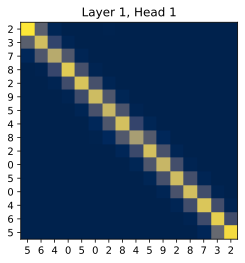

In [29]:
plot_attention_maps(data_input, attention_maps, idx=0)

The model has learned to attend to the token that is on the flipped index of itself. Hence, it actually does what we intended it to do. We see that it however also pays some attention to values close to the flipped index. This is because the model doesn't need the perfect, hard attention to solve this problem, but is fine with this approximate, noisy attention map. The close-by indices are caused by the similarity of the positional encoding, which we also intended with the positional encoding.

### Set Anomaly Detection

Besides sequences, sets are another data structure that is relevant for many applications. In contrast to sequences, elements are unordered in a set. RNNs can only be applied on sets by assuming an order in the data, which however biases the model towards a non-existing order in the data. [Vinyals et al. (2015)](https://arxiv.org/abs/1511.06391) and other papers have shown that the assumed order can have a significant impact on the model's performance, and hence, we should try to not use RNNs on sets. Ideally, our model should be permutation-equivariant/invariant such that the output is the same no matter how we sort the elements in a set. 

Transformers offer the perfect architecture for this as the Multi-Head Attention is permutation-equivariant, and thus, outputs the same values no matter in what order we enter the inputs (inputs and outputs are permuted equally). The task we are looking at for sets is _Set Anomaly Detection_ which means that we try to find the element(s) in a set that does not fit the others. In the research community, the common application of anomaly detection is performed on a set of images, where $N-1$ images belong to the same category/have the same high-level features while one belongs to another category. Note that category does not necessarily have to relate to a class in a standard classification problem, but could be the combination of multiple features. For instance, on a face dataset, this could be people with glasses, male, beard, etc. An example of distinguishing different animals can be seen below. The first four images show foxes, while the last represents a different animal. We want to recognize that the last image shows a different animal, but it is not relevant which class of animal it is.

<center width="100%" style="padding:20px"><img src="../../tutorial6/cifar100_example_anomaly.png" width="600px"></center>

In this tutorial, we will use the CIFAR100 dataset. CIFAR100 has 600 images for 100 classes each with a resolution of 32x32, similar to CIFAR10. The larger amount of classes requires the model to attend to specific features in the images instead of coarse features as in CIFAR10, therefore making the task harder. We will show the model a set of 9 images of one class, and 1 image from another class. The task is to find the image that is from a different class than the other images.
Using the raw images directly as input to the Transformer is not a good idea, because it is not translation invariant as a CNN, and would need to learn to detect image features from high-dimensional input first of all. Instead, we will use a pre-trained ResNet34 model from the package `flaxmodels` ([link](https://github.com/matthias-wright/flaxmodels)) to obtain high-level, low-dimensional features of the images. The ResNet model has been pre-trained on the [ImageNet](http://image-net.org/) dataset which contains 1 million images of 1k classes and varying resolutions. However, during training and testing, the images are usually scaled to a resolution of 224x224, and hence we rescale our CIFAR images to this resolution as well. Below, we will load the dataset, and prepare the data for being processed by the ResNet model.

In [30]:
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = img / 255.   # Normalization is done in the ResNet
    return img

# Resize to 224x224, and map to JAX
transform = transforms.Compose([transforms.Resize((224,224)),
                                image_to_numpy
                               ])
# Loading the training dataset. 
train_set = CIFAR100(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = CIFAR100(root=DATASET_PATH, train=False, transform=transform, download=True)

# For later, keep a dictionary mapping class indices to class names
class_idx_to_name = {val: key for key, val in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


Next, we want to run the pre-trained ResNet model on the images, and extract the features before the classification layer. These are the most high-level features, and should sufficiently describe the images. CIFAR100 has some similarity to ImageNet, and thus we are not retraining the ResNet model in any form. However, if you would want to get the best performance and have a very large dataset, it would be better to add the ResNet to the computation graph during training and finetune its parameters as well. As we don't have a large enough dataset and want to train our model efficiently, we will extract the features beforehand. Let's load and prepare the model below.

In [31]:
# Import and install flaxmodels if needed
try:
    import flaxmodels
except ModuleNotFoundError:
    !pip install --upgrade git+https://github.com/matthias-wright/flaxmodels.git
    import flaxmodels

# Pretrained ResNet34 on ImageNet
resnet34 = flaxmodels.ResNet34(output='activations', pretrained='imagenet', normalize=True)
main_rng, resnet_rng = random.split(main_rng, 2)
resnet_params = resnet34.init(resnet_rng, jnp.zeros((1, 224, 224, 3)))
# Jit its forward pass for efficiency
apply_resnet = jax.jit(lambda imgs: resnet34.apply(resnet_params, imgs, train=False))

We will now write a extraction function for the features below. This cell requires access to a GPU, as the model is rather deep and the images relatively large. The GPUs on GoogleColab are sufficient, but running this cell can take 2-3 minutes. Once it is run, the features are exported on disk so they don't have to be recalculated every time you run the notebook. However, this requires >150MB free disk space. So it is recommended to run this only on a local computer if you have enough free disk and a GPU (GoogleColab is fine for this). If you do not have a GPU, you can download the features from the [GoogleDrive folder](https://drive.google.com/drive/folders/1t8D-GTfmxJ42xLNTeMGMKSYuWBua5lXI?usp=sharing).

In [32]:
def extract_features(dataset, save_file):
    if not os.path.isfile(save_file):
        data_loader = data.DataLoader(dataset, batch_size=128, shuffle=False, drop_last=False, 
                                      collate_fn=lambda batch: np.stack([b[0] for b in batch], axis=0))
        extracted_features = []
        for imgs in tqdm(data_loader):
            feats = apply_resnet(imgs)
            # Average pooling on the last conv features to obtain a image-level feature vector
            feats = feats['block4_2'].mean(axis=(1,2))
            extracted_features.append(feats)
        extracted_features = jnp.concatenate(extracted_features, axis=0)
        extracted_features = jax.device_get(extracted_features)
        np.savez_compressed(save_file, feats=extracted_features)
    else:
        extracted_features = np.load(save_file)['feats']
    return extracted_features

train_feat_file = os.path.join(CHECKPOINT_PATH, "train_set_features.npz")
train_set_feats = extract_features(train_set, train_feat_file)

test_feat_file = os.path.join(CHECKPOINT_PATH, "test_set_features.npz")
test_feats = extract_features(test_set, test_feat_file)

Let's verify the feature shapes below. The training should have 50k elements, and the test 10k images. The feature dimension is 512 for the ResNet34. If you experiment with other models, you likely see a different feature dimension.

In [33]:
print("Train:", train_set_feats.shape)
print("Test: ", test_feats.shape)

Train: (50000, 512)
Test:  (10000, 512)


As usual, we want to create a validation set to detect when we should stop training. In this case, we will split the training set into 90% training, 10% validation. However, the difficulty is here that we need to ensure that the validation set has the same number of images for all 100 labels. Otherwise, we have a class imbalance which is not good for creating the image sets. Hence, we take 10% of the images for each class, and move them into the validation set. The code below does exactly this.

In [34]:
## Split train into train+val
# Get labels from train set
labels = np.array(train_set.targets, dtype=np.int32)

# Get indices of images per class
num_labels = labels.max()+1
sorted_indices = np.argsort(labels).reshape(num_labels, -1) # [classes, num_imgs per class]

# Determine number of validation images per class
num_val_exmps = sorted_indices.shape[1] // 10

# Get image indices for validation and training
val_indices   = sorted_indices[:,:num_val_exmps].reshape(-1)
train_indices = sorted_indices[:,num_val_exmps:].reshape(-1)

# Group corresponding image features and labels
train_feats, train_labels = train_set_feats[train_indices], labels[train_indices]
val_feats,   val_labels   = train_set_feats[val_indices],   labels[val_indices]

Now we can prepare a dataset class for the set anomaly task. We define an epoch to be the sequence in which each image has been exactly once as an "anomaly". Hence, the length of the dataset is the number of images in it. For the training set, each time we access an item with `__getitem__`, we sample a random, different class than the image at the corresponding index `idx` has. In a second step, we sample $N-1$ images of this sampled class. The set of 10 images is finally returned. The randomness in the `__getitem__` allows us to see a slightly different set during each iteration. However, we can't use the same strategy for the test set as we want the test dataset to be the same every time we iterate over it. Hence, we sample the sets in the `__init__` method, and return those in `__getitem__`. The code below implements exactly this dynamic.

In [35]:
class SetAnomalyDataset(data.Dataset):
    
    def __init__(self, img_feats, labels, np_rng, set_size=10, train=True):
        """
        Inputs:
            img_feats - Tensor of shape [num_imgs, img_dim]. Represents the high-level features.
            labels - Tensor of shape [num_imgs], containing the class labels for the images
            set_size - Number of elements in a set. N-1 are sampled from one class, and one from another one.
            train - If True, a new set will be sampled every time __getitem__ is called.
        """
        super().__init__()
        self.img_feats = img_feats
        self.labels = labels
        self.np_rng = np_rng
        self.set_size = set_size-1  # The set size is here the number of images from the same class per set
        self.train = train
        
        # Tensors with indices of the images per class
        self.num_labels = labels.max()+1
        self.img_idx_by_label = np.argsort(self.labels).reshape(self.num_labels, -1)
        
        if not train:
            self.test_sets = self._create_test_sets()
            
    def _create_test_sets(self):
        # Pre-generates the sets for each image for the test set
        test_sets = []
        num_imgs = self.img_feats.shape[0]
        test_sets = [self.sample_img_set(self.labels[idx]) for idx in range(num_imgs)]
        test_sets = np.stack(test_sets, axis=0)
        return test_sets
               
    def sample_img_set(self, anomaly_label):
        """
        Samples a new set of images, given the label of the anomaly. 
        The sampled images come from a different class than anomaly_label
        """
        # Sample class from 0,...,num_classes-1 while skipping anomaly_label as class
        set_label = self.np_rng.integers(self.num_labels-1)
        if set_label >= anomaly_label:
            set_label += 1
            
        # Sample images from the class determined above
        img_indices = self.np_rng.choice(self.img_idx_by_label.shape[1], size=self.set_size, replace=False)
        img_indices = self.img_idx_by_label[set_label, img_indices]
        return img_indices
        
    def __len__(self):
        return self.img_feats.shape[0]
    
    def __getitem__(self, idx):
        anomaly = self.img_feats[idx]
        if self.train: # If train => sample
            img_indices = self.sample_img_set(self.labels[idx])
        else: # If test => use pre-generated ones
            img_indices = self.test_sets[idx]
            
        # Concatenate images. The anomaly is always the last image for simplicity
        img_set = np.concatenate([self.img_feats[img_indices], anomaly[None]], axis=0)
        indices = np.concatenate([img_indices, np.array([idx], dtype=np.int32)], axis=0)
        label = img_set.shape[0]-1
        
        # We return the indices of the images for visualization purpose. "Label" is the index of the anomaly
        return img_set, indices, label

Next, we can setup our datasets and data loaders below. Here, we will use a set size of 10, i.e. 9 images from one category + 1 anomaly. Feel free to change it if you want to experiment with the sizes. 

In [36]:
SET_SIZE = 10
test_labels = np.array(test_set.targets, dtype=np.int32)

anom_train_dataset = SetAnomalyDataset(train_feats, train_labels, np_rng=np.random.default_rng(42), set_size=SET_SIZE, train=True)
anom_val_dataset   = SetAnomalyDataset(val_feats,   val_labels,   np_rng=np.random.default_rng(43), set_size=SET_SIZE, train=False)
anom_test_dataset  = SetAnomalyDataset(test_feats,  test_labels,  np_rng=np.random.default_rng(123), set_size=SET_SIZE, train=False)

anom_train_loader = data.DataLoader(anom_train_dataset, batch_size=64, shuffle=True,  drop_last=True,  collate_fn=numpy_collate)
anom_val_loader   = data.DataLoader(anom_val_dataset,   batch_size=64, shuffle=False, drop_last=False, collate_fn=numpy_collate)
anom_test_loader  = data.DataLoader(anom_test_dataset,  batch_size=64, shuffle=False, drop_last=False, collate_fn=numpy_collate)

To understand the dataset a little better, we can plot below a few sets from the test dataset. Each row shows a different input set, where the first 9 are from the same class.

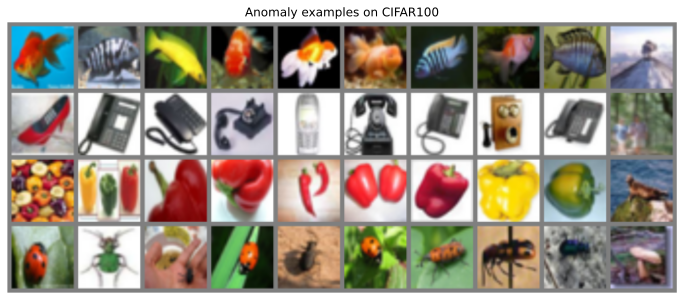

In [37]:
def visualize_exmp(indices, orig_dataset):
    images = [orig_dataset[idx][0] for idx in indices.reshape(-1)]
    images = jax.device_get(jnp.stack(images, axis=0)).astype(np.float32)
    images = torch.from_numpy(images)
    images = images.permute(0, 3, 1, 2)
    img_grid = torchvision.utils.make_grid(images, nrow=SET_SIZE, normalize=True, pad_value=0.5, padding=16)
    img_grid = img_grid.permute(1, 2, 0)

    plt.figure(figsize=(12,8))
    plt.title("Anomaly examples on CIFAR100")
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()
    plt.close()

_, indices, _ = next(iter(anom_test_loader))
visualize_exmp(indices[:4], test_set)

We can already see that for some sets the task might be easier than for others. Difficulties can especially arise if the anomaly is in a different, but yet visually similar class (e.g. insect vs mushroom, train vs bus, etc.).

After having prepared the data, we can look closer at the model. Here, we have a classification of the whole set. For the prediction to be permutation-equivariant, we will output one logit for each image. Over these logits, we apply a softmax and train the anomaly image to have the highest score/probability. This is a bit different than a standard classification layer as the softmax is applied over images, not over output classes in the classical sense. However, if we swap two images in their position, we effectively swap their position in the output softmax. Hence, the prediction is equivariant with respect to the input. Furthermore, we need to remove the positional encoding since these features would break the permutation equivariance. We implement this setup below in the subclass of the Trainer module.

In [38]:
class AnomalyTrainer(TrainerModule):
    
    def batch_to_input(self, batch):
        inp_data, _, _ = batch
        return inp_data
    
    def get_loss_function(self):
        # Function for calculating loss and accuracy for a batch
        def calculate_loss(params, rng, batch, train):
            inp_data, _, labels = batch
            rng, dropout_apply_rng = random.split(rng)
            logits = self.model.apply({'params': params}, inp_data, 
                                      add_positional_encoding=False,  # No positional encoding since this is a permutation equivariant task
                                      train=train, 
                                      rngs={'dropout': dropout_apply_rng})
            logits = logits.squeeze(axis=-1)
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (logits.argmax(axis=-1) == labels).astype(jnp.float32).mean()
            return loss, (acc, rng)
        return calculate_loss

Finally, we write our train function below. It has the exact same structure as the reverse task one, hence not much of an explanation is needed here.

In [39]:
def train_anomaly(max_epochs=100, **model_args):
    num_train_iters = len(anom_train_loader) * max_epochs
    # Create a trainer module with specified hyperparameters
    trainer = AnomalyTrainer(model_name='SetAnomalyTask', 
                             exmp_batch=next(iter(anom_train_loader)),
                             max_iters=num_train_iters, 
                             **model_args)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(anom_train_loader, anom_val_loader, num_epochs=max_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    train_acc = trainer.eval_model(anom_train_loader)
    val_acc = trainer.eval_model(anom_val_loader)
    test_acc = trainer.eval_model(anom_test_loader)
    # Bind parameters to model for easier inference
    trainer.model_bd = trainer.model.bind({'params': trainer.state.params})
    return trainer, {'train_acc': train_acc, 'val_acc': val_acc, 'test_acc': test_acc}

Let's finally train our model. We will use 4 layers with 4 attention heads each. The hidden dimensionality of the model is 256, and we use a dropout of 0.1 throughout the model for good regularization. Note that we also apply the dropout on the input features, as this makes the model more robust against image noise and generalizes better. Again, we use warmup to slowly start our model training. 

In [40]:
anomaly_trainer, anomaly_result = train_anomaly(model_dim=256,
                                                num_heads=4,
                                                num_classes=1,
                                                num_layers=4,
                                                dropout_prob=0.1,
                                                input_dropout_prob=0.1,
                                                lr=5e-4,
                                                warmup=100)

We can print the achieved accuracy below.

In [41]:
print(f"Train accuracy: {(100.0*anomaly_result['train_acc']):4.2f}%")
print(f"Val accuracy:   {(100.0*anomaly_result['val_acc']):4.2f}%")
print(f"Test accuracy:  {(100.0*anomaly_result['test_acc']):4.2f}%")

Train accuracy: 98.37%
Val accuracy:   94.50%
Test accuracy:  94.66%


With ~94% validation and test accuracy, the model generalizes quite well. It should be noted that you might see slightly different scores depending on what computer/device you are running this notebook. This is because despite setting the seed before generating the test dataset, it may not always be the same across platforms and numpy versions. Nevertheless, we can conclude that the model performs quite well and can solve the task for most sets. Before trying to interpret the model, let's verify that our model is permutation-equivariant, and assigns the same predictions for different permutations of the input set. For this, we sample a batch from the test set and run it through the model to obtain the probabilities. 

In [42]:
inp_data, indices, labels = next(iter(anom_test_loader))
preds = anomaly_trainer.model_bd(inp_data, add_positional_encoding=False, train=False)
preds = jax.nn.softmax(preds.squeeze(axis=-1))

permut = np.random.permutation(inp_data.shape[1])
permut_inp_data = inp_data[:,permut]
perm_preds = anomaly_trainer.model_bd(permut_inp_data, add_positional_encoding=False, train=False)
perm_preds = jax.nn.softmax(perm_preds.squeeze(axis=-1))

preds = jax.device_get(preds)
perm_preds = jax.device_get(perm_preds)

assert np.abs(preds[:,permut] - perm_preds).max() < 1e-5, "Predictions are not permutation equivariant"

print("Preds\n", preds[0,permut])
print("Permuted preds\n", perm_preds[0])

Preds
 [1.3902171e-07 4.3522828e-08 5.2554757e-08 1.2441276e-08 2.7709259e-08
 9.9999952e-01 5.5640967e-08 3.5155960e-08 1.4563368e-08 4.8264688e-08]
Permuted preds
 [1.3902175e-07 4.3522839e-08 5.2554768e-08 1.2441279e-08 2.7709264e-08
 9.9999976e-01 5.5640978e-08 3.5155971e-08 1.4563372e-08 4.8264699e-08]


You can see that the predictions are almost exactly the same, and only differ because of slight numerical differences inside the network operation.

To interpret the model a little more, we can plot the attention maps inside the model. This will give us an idea of what information the model is sharing/communicating between images, and what each head might represent. First, we need to extract the attention maps for the test batch above, and determine the discrete predictions for simplicity.

In [43]:
attention_maps = anomaly_trainer.model_bd.get_attention_maps(inp_data, add_positional_encoding=False, train=False)
predictions = preds.argmax(axis=-1)

Below we write a plot function which plots the images in the input set, the prediction of the model, and the attention maps of the different heads on layers of the transformer. Feel free to explore the attention maps for different input examples as well.

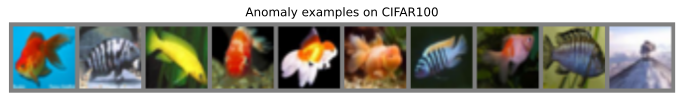

Main class: aquarium_fish, Anomaly class: mountain
Prediction: image 9


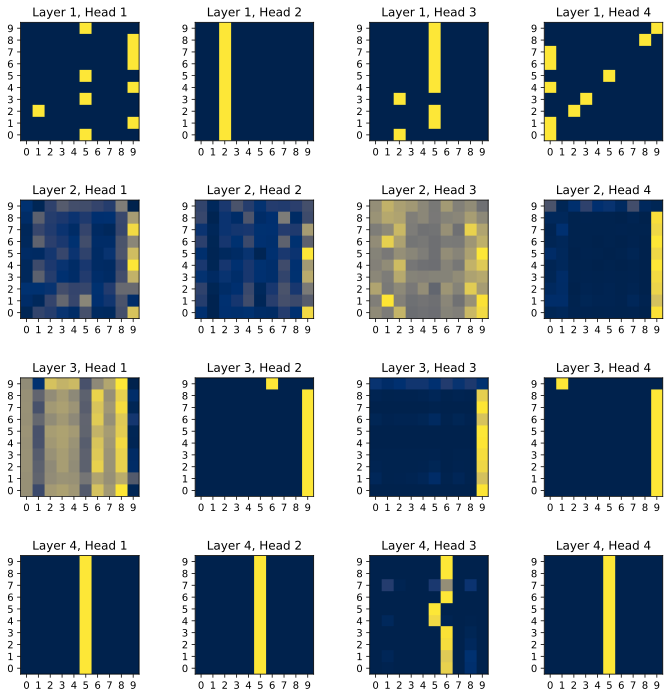

In [44]:
def visualize_prediction(idx):
    visualize_exmp(indices[idx:idx+1], test_set)
    print(f'Main class: {class_idx_to_name[test_labels[indices[idx,0]]]}, Anomaly class: {class_idx_to_name[test_labels[indices[idx,-1]]]}')
    print(f'Prediction: image {predictions[idx].item()}')
    plot_attention_maps(input_data=None, attn_maps=attention_maps, idx=idx)

visualize_prediction(0)

Depending on the random seed, you might see a slightly different input set. For the version on the website, we compare 9 aquarium fish images with a volcano/mountain. We see that multiple heads, for instance, Layer 2 Head 1, Layer 2 Head 4, and Layer 3 Head 2-4 focus on the last image. Additionally, the heads in Layer 4 all seem to ignore the last image and assign a very low attention probability to it. This shows that the model has indeed recognized that the image doesn't fit the setting, and hence predicted it to be the anomaly. Layer 2 Head 3 and Layer 3 Head 1 seems to take a slightly weighted average of all images. That might indicate that the model extracts the "average" information of all images, to compare it to the image features itself. 

Let's try to find where the model actually makes a mistake. We can do this by identifying the sets where the model predicts something else than 9, as in the dataset, we ensured that the anomaly is always at the last position in the set.

In [45]:
mistakes = np.where(predictions != 9)[0]
print("Indices with mistake:", mistakes)

Indices with mistake: [10 58]


As our model achieves ~94% accuracy, we only have very little number of mistakes in a batch of 64 sets. Still, let's visualize one of them, for example the last one:

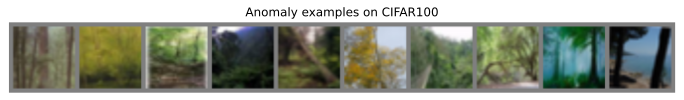

Main class: forest, Anomaly class: sea
Prediction: image 3


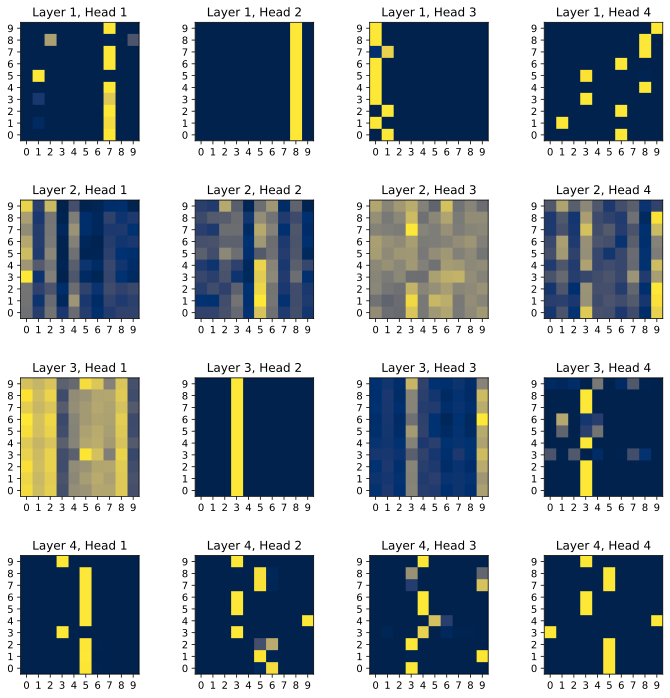

Probabilities:
Image 0: 0.84%
Image 1: 1.53%
Image 2: 1.00%
Image 3: 54.88%
Image 4: 2.39%
Image 5: 6.54%
Image 6: 4.91%
Image 7: 1.44%
Image 8: 1.39%
Image 9: 25.09%


In [46]:
visualize_prediction(mistakes[0])
print("Probabilities:")
for i, p in enumerate(preds[mistakes[0]]):
    print(f"Image {i}: {100.0*p:4.2f}%")

In this example, the model confuses a picture of a sea with a forest, giving a probability of ~55% to image 3, and 25% to the actual anomaly. However, the difficulty here is that the picture of the sea actually contains trees in the foreground, which makes the image a bit of an ambiguous class. It is possible a picture of a sea taken out of a forest, which confuses the model. Nevertheless, in general, the model performs quite well.

## Conclusion

In this tutorial, we took a closer look at the Multi-Head Attention layer which uses a scaled dot product between queries and keys to find correlations and similarities between input elements. The Transformer architecture is based on the Multi-Head Attention layer and applies multiple of them in a ResNet-like block. The Transformer is a very important, recent architecture that can be applied to many tasks and datasets. Although it is best known for its success in NLP, there is so much more to it. We have seen its application on sequence-to-sequence tasks and set anomaly detection. Its property of being permutation-equivariant if we do not provide any positional encodings, allows it to generalize to many settings. Hence, it is important to know the architecture, but also its possible issues such as the gradient problem during the first iterations solved by learning rate warm-up. If you are interested in continuing with the study of the Transformer architecture, please have a look at the blog posts listed at the beginning of the tutorial notebook.

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/phlippe/uvadlc_notebooks/)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/phlippe/uvadlc_notebooks/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub. 

---